# Mean Variance Optimization (MVO) and Efficient Frontier Overview

Mean–Variance Optimization (MVO) is a classical framework for portfolio construction that balances **expected return and risk**, where risk is measured by the **variance (or volatility)** of portfolio returns.
By solving a sequence of constrained optimization problems, one can trace out the **efficient frontier**, which represents the set of portfolios that achieve the lowest possible risk for a given level of expected return.

In this framework, asset returns are summarized by their expected values and covariance structure. Portfolio weights are chosen to minimize total variance subject to budget and return constraints. Convex optimization techniques are used to ensure numerical stability and extensibility.

### Variables:
- $ r_t $: Vector of asset returns at time
𝑡
- $ μ $: Vector of expected asset returns
- $ Σ $: Covariance matrix of asset returns
- $ w $: Portfolio weight vector
- $ R $: Target portfolio return
- $ N $: Number of assets

### Steps to Compute the Efficient Frontier:
1. **Estimate return statistics**: Compute the expected returns 𝜇 and covariance matrix Σ from historical return data.
2. **Formulate the optimization problem**: For a given target return 𝑅, solve the minimum-variance portfolio problem:
   - Minimize portfolio variance  $w^\top \Sigma w$
   - Subject to budget and return constraints.
3. **Solve for optimal weights**: Use convex optimization to obtain the portfolio weights that satisfy the constraints.
4. **Sweep target returns**:
Repeat the optimization over a grid of target returns to generate the full efficient frontier.

### Result:
The collection of solutions forms the efficient frontier, which characterizes the optimal trade-off between risk and expected return.

Each point on the frontier corresponds to a portfolio allocation that is mean–variance efficient under the specified constraints.


# Implementation and an Example

Consider a simple portfolio optimization setup with **N = 4** assets.
The dataset spans the period **1960–2002** and consists of total returns from the following asset classes:

  - S&P 500 equity index

  - Long-term bonds

  - Money market account

  - NASDAQ stocks

**Expected portfolio returns 𝑅** are evaluated over a range from **6.5%** to **10.5%**, with increments of **0.5%**.

Based on the return data, the expected return vector μ and the covariance matrix Σ are estimated and used as inputs to a mean–variance optimization framework. For each target return level 𝑅, a minimum-variance portfolio is computed under standard budget and long-only constraints.

The resulting portfolio weights, expected returns, and volatilities are then collected to construct the efficient frontier.

In [1]:
!pip install cvxpy
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('mvo-data.csv', sep = ' ', header=None).dropna(axis=1)
data.index = np.arange(1960, 2004)
data.columns = ['stocks_SP500', 'bonds', 'market_account', 'stocks_Nasdaq']

In [3]:
data.head()

,stocks_SP500,bonds,market_account,stocks_Nasdaq
1960,20.2553,262.935,100.00,34.461
1961,25.6860,268.730,102.33,45.373
1962,23.4297,284.090,105.33,38.556
1963,28.7463,289.162,108.89,46.439
1964,33.4484,299.894,113.08,57.175


## Step 1
Prepare the mean vector, covariance matrix and expected returns

In [4]:
# rate of return matrix
r = data.pct_change(1).dropna(axis=0)
r.head()

,stocks_SP500,bonds,market_account,stocks_Nasdaq
1961,0.268113,0.022040,0.023300,0.316648
1962,-0.087842,0.057158,0.029317,-0.150244
1963,0.226917,0.017853,0.033799,0.204456
1964,0.163572,0.037114,0.038479,0.231185
1965,0.123560,0.009340,0.043244,0.171526


In [5]:
# arithmetic mean
arith_mean = np.mean(r, axis=0)
arith_mean

,0
stocks_SP500,0.120571
bonds,0.078502
market_account,0.063230
stocks_Nasdaq,0.128991


In [7]:
# geometric mean
geo_mean = np.exp(np.log1p(r).mean(axis=0)) - 1 # note here .lop1p already add 1 to r
geo_mean

,0
stocks_SP500,0.107321
bonds,0.073669
market_account,0.062701
stocks_Nasdaq,0.099091


In [8]:
# centered matrix (r_it - mean(r_1))
r_centered = r - arith_mean # here msut use arithmetic mean

In [9]:
# covariance matrix V
V = r_centered.T.dot(r_centered) / r.shape[0]
V

,stocks_SP500,bonds,market_account,stocks_Nasdaq
stocks_SP500,0.027782,0.003866,0.000207,0.034909
bonds,0.003866,0.011121,-0.000195,-0.000543
market_account,0.000207,-0.000195,0.001154,-0.000429
stocks_Nasdaq,0.034909,-0.000543,-0.000429,0.063435


In [19]:
# define the expected returns
Rs = np.arange(0.065, 0.11, 0.005)

## Step 2
Use the package CVXPY is used to construct the MVO solver. Using the solver to get the weights for each optimal portfolio with different expected returns, then calculate the standard deviation and true return from those portfolios.

In [20]:
# create the function to solve this problem
def MVO_solver(n, R, mu, Sigma):
  """
    Solve a mean–variance portfolio optimization problem with a minimum
    target return constraint.

    The function computes the minimum-variance portfolio subject to:
    - a full-investment (budget) constraint,
    - a minimum expected return requirement,
    - and long-only weights.

    Parameters
    ----------
    n : int
        Number of assets in the portfolio.
    R : float
        Minimum target portfolio return.
    mu : array_like, shape (n,) or (1, n)
        Expected returns of the assets.
    Sigma : array_like, shape (n, n)
        Covariance matrix of asset returns.

    Returns
    -------
    numpy.ndarray, shape (n,)
        Optimal portfolio weights that minimize variance while satisfying
        the constraints.

    Notes
    -----
    This problem is formulated as a convex quadratic program and is solved
    using CVXPY. The default solver is selected automatically by CVXPY.
  """
  mu = np.asarray(mu).reshape(-1)
  Sigma = np.asarray(Sigma)

  x = cp.Variable(n) # x is the weight vector we want to get

  objective = cp.Minimize(cp.quad_form(x, Sigma)) # given expected return, minimize standard deviation

  constraints = [
      cp.sum(x) == 1,
      mu @ x >= R,
      x >= 0 # here we don't allow short
  ]

  prob = cp.Problem(objective, constraints)
  prob.solve()

  return x.value

In [21]:
# pass the result to weights matrix
weights = pd.DataFrame(
    [MVO_solver(r.shape[1], R, arith_mean, V) for R in Rs],
    index=Rs,
    columns=data.columns)
weights.index.name = 'target_returns'

pd.set_option('display.float_format','{:.5f}'.format)
weights

,stocks_SP500,bonds,market_account,stocks_Nasdaq
target_returns,,,,
0.06500,0.00000,0.10436,0.87342,0.02222
0.07000,0.03467,0.13542,0.78864,0.04127
0.07500,0.13223,0.14870,0.68993,0.02914
0.08000,0.22980,0.16197,0.59121,0.01702
0.08500,0.32737,0.17524,0.49250,0.00490
0.09000,0.41577,0.19179,0.39243,-0.00000
0.09500,0.49797,0.21057,0.29146,-0.00000
0.10000,0.58017,0.22935,0.19048,-0.00000
0.10500,0.66237,0.24813,0.08951,0.00000


In [22]:
# store the standard deviation of each optimal portfolio and the corresponding expected return
effft = pd.DataFrame(
    index = Rs,
    columns = ['Standard Deviation', 'Expected Return'])
effft.index.name = 'target_returns'

effft['Standard Deviation'] = [np.sqrt(w @ V @ w) for w in weights.values]
effft['Expected Return'] = [arith_mean @ w for w in weights.values]

effft

,Standard Deviation,Expected Return
target_returns,,
0.06500,0.03127,0.06629
0.07000,0.03369,0.07000
0.07500,0.04161,0.07500
0.08000,0.05243,0.08000
0.08500,0.06470,0.08500
0.09000,0.07774,0.09000
0.09500,0.09125,0.09500
0.10000,0.10505,0.10000
0.10500,0.11903,0.10500


## Step 3
The standard deviation (risk) and expected return sets for the optimal weighted portfolios are obtained, we can use them to plot the efficient frontier.

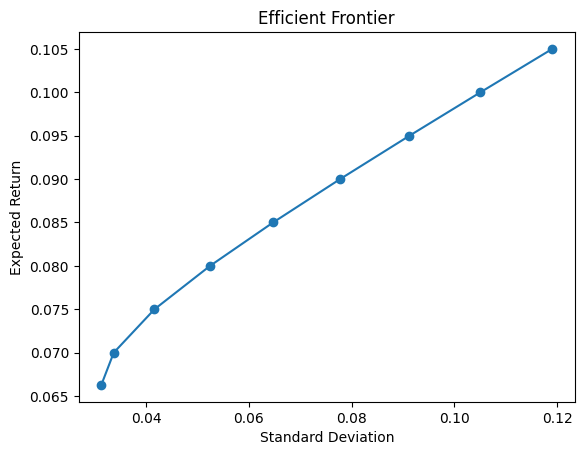

In [23]:
plt.figure()
plt.plot(
    effft['Standard Deviation'],
    effft['Expected Return'],
    marker = 'o',
)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()